In [1]:
import numpy as np
import matplotlib.pyplot as plt
from specutils.spectra.spectrum1d import Spectrum1D
from specutils.fitting import fit_lines
from scipy.signal import correlate
from scipy.signal import correlation_lags
from specutils.analysis import correlation #correlation.template_correlate
import astropy.units as u
from astropy.time import Time
from scipy.optimize import curve_fit
from PyAstronomy.pyasl import crosscorrRV

from scipy.special import voigt_profile, wofz
from astropy.modeling.models import Voigt1D
from scipy.stats import chi2

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def voigt_pro(x, mu, sigma, gamma, F, A):
    return -F*voigt_profile(x-mu, sigma, gamma) + A


def get_sorted_list_and_per(list1, per=True):
    L = [(list1[i],i) for i in range(len(list1))]
    L.sort()
    sorted_list, permutation = zip(*L)
    sorted_list = list(sorted_list)
    if per == True:
        return sorted_list, permutation
    if per == False:
        return sorted_list

def sort_with_per(to_sort_list, permutation):
    sorted_list = []
    for index2 in permutation:
        sorted_list.append(to_sort_list[index2])
    return sorted_list

import pandas as pd
from astropy.io import fits
from astropy.time import TimeDelta

def extract_middle_time(datafile_path):
    '''datafile_path zu obj_raw.fits'''
    fitsheader = fits.open(datafile_path)[0].header
    ncomb = fitsheader.get('NCOMBINE',1)
    if ncomb == 1:
        start_time = Time(fitsheader.get('DATE-OBS', 0), format = 'isot')
        exp_time = TimeDelta(float(fitsheader['EXPOSURE']) * u.second, format = 'sec')
        middle_time = start_time + exp_time/2
    elif ncomb > 1:
        start_time_list = []
        exp_time_list = []
        for file in os.listdir(datafile_path[:-13]):
            path = os.path.join(datafile_path[:-13], file)
            if file.endswith("000.fits") or file.endswith('000.c2k.fits'):
                filepath = os.path.join(datafile_path[:-13], file)
                start_time_list.append(Time(fits.open(filepath)[0].header['DATE-OBS'], format = 'isot'))
                exp_time_list.append(TimeDelta(float(fits.open(filepath)[0].header['EXPOSURE']) * u.second, format = 'sec'))
        start_time_list, per = get_sorted_list_and_per(start_time_list)
        exp_time_list = sort_with_per(exp_time_list, per)
        middle_time = start_time_list[0]+ ((start_time_list[-1]+exp_time_list[-1])-start_time_list[0])/2
    else:
        raise ValueError(f'ncomb is {ncomb} for {datafile_path}')
    return middle_time

def calc_p(shifts, errors):
    N = len(shifts)
    weights = 1/np.array(errors)**2
    weighted_mean_shift = np.average(shifts, weights = weights)

    chi_squared = np.sum(((shifts-weighted_mean_shift)**2)/(errors**2))
    
    dof = N-1

    p = chi2.sf(chi_squared, dof)

In [3]:
import os

datafile_path_list = []
datafile_path_list_UV = []
datafile_path_list_VIS = []
time_list = []
time_list_UV = []
time_list_VIS = []
for file in os.listdir("/home/birger/Schreibtisch/Bachelorarbeit/OBJECT_FIVE:TYC4454-1229-1"):
    if file.endswith(".txt") and not file.endswith("VIS.txt") and not file.endswith('table.txt'):
        datafile_path_list.append(os.path.join("/home/birger/Schreibtisch/Bachelorarbeit/OBJECT_FIVE:TYC4454-1229-1", file))
        datafile_path_list_UV.append(os.path.join("/home/birger/Schreibtisch/Bachelorarbeit/OBJECT_FIVE:TYC4454-1229-1", file))
        time_list.append(file[:23])
        time_list_UV.append(file[:23])
    elif file.endswith("VIS.txt") and not file.endswith('table.txt'):
        datafile_path_list.append(os.path.join("/home/birger/Schreibtisch/Bachelorarbeit/OBJECT_FIVE:TYC4454-1229-1", file))
        datafile_path_list_VIS.append(os.path.join("/home/birger/Schreibtisch/Bachelorarbeit/OBJECT_FIVE:TYC4454-1229-1", file))
        time_list.append(file[:23])
        time_list_VIS.append(file[:23])

time_list, per = get_sorted_list_and_per(time_list)
time_list_UV, per_UV = get_sorted_list_and_per(time_list_UV)
time_list_VIS, per_VIS = get_sorted_list_and_per(time_list_VIS)
datafile_path_list = sort_with_per(datafile_path_list, per)
datafile_path_list_UV = sort_with_per(datafile_path_list_UV, per_UV)
datafile_path_list_VIS = sort_with_per(datafile_path_list_VIS, per_VIS)

time_per_UV = []
time_per_VIS = []

for i, time in enumerate(time_list):
    if time in time_list_UV:
        time_per_UV.append(i)
    if time in time_list_VIS:
        time_per_VIS.append(i)
print(time_per_UV)
print(time_per_VIS)
    

time_objects = [Time.strptime(time_string, "%Y-%m-%d_%H-%M-%S.%f") for time_string in time_list]
print(time_list)


[0, 2, 6, 7, 9]
[1, 3, 4, 5, 8]
['2023-05-08_23-57-27.000', '2023-05-09_23-09-24.000', '2023-07-22_22-57-54.000', '2024-01-29_22-37-03.000', '2024-01-31_21-39-00.000', '2024-04-23_01-06-57.000', '2024-08-11_00-43-59.000', '2024-08-17_01-35-17.000', '2024-10-18_20-03-42.000', '2025-01-21_00-03-05.000']


In [4]:
UV_wave = []
UV_flux = []

for datafile_path in datafile_path_list_UV:
    wave, flux = np.loadtxt(datafile_path, unpack=True)
    UV_wave.append(wave)
    UV_flux.append(flux)

VIS_wave = []
VIS_flux = []

for datafile_path in datafile_path_list_VIS:
    wave, flux = np.loadtxt(datafile_path, unpack=True)
    VIS_wave.append(wave)
    VIS_flux.append(flux)

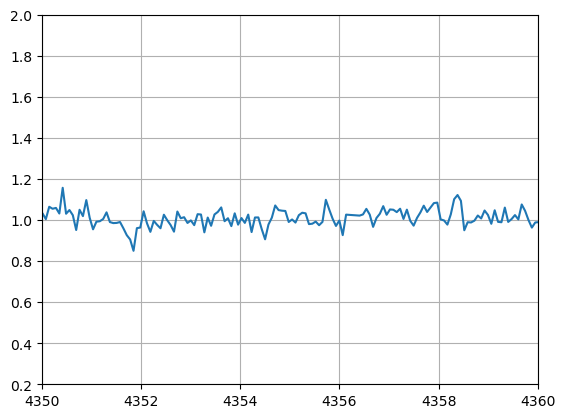

In [5]:
i, *w = (3, 4356.2, 4356.4)

to_ = slice(find_nearest(UV_wave[i], w[0]), find_nearest(UV_wave[i], w[1]))
plt.plot(np.delete(UV_wave[i],to_), np.delete(UV_flux[i], to_))
plt.xlim(4350, 4360)
plt.ylim(0.2,2)
plt.grid()
plt.show() #slice(find_nearest(all_wave[ind], 6562.55), find_nearest(all_wave[ind], 6563.45))

In [6]:
to_remove_list_UV = [(0, 4333.6, 4333.9), (0, 4334.9, 4335), (2, 4335, 4335.27), (2, 4349.8, 4350), (1, 4852.3, 4852.45), (0, 3963.65, 3963.75), (0, 3979.9, 3980), (3, 3963.8, 3964), (3, 3966.55, 3967.1), (3, 3969.99, 3970.3), (3, 3965.7, 3966), (0, 4321.43, 4321.68), (3, 4356.2, 4356.4)]

for inde, wave_1, wave_2 in to_remove_list_UV:
    slice_to_remove = slice(find_nearest(UV_wave[inde], wave_1), find_nearest(UV_wave[inde], wave_2))
    UV_wave[inde] = np.delete(UV_wave[inde], slice_to_remove)
    UV_flux[inde] = np.delete(UV_flux[inde], slice_to_remove)

to_remove_list_VIS = [(0, 4868.2, 4868.4), (0, 4873.3, 4873.5)]

for inde, wave_1, wave_2 in to_remove_list_VIS:
    slice_to_remove = slice(find_nearest(VIS_wave[inde], wave_1), find_nearest(VIS_wave[inde], wave_2))
    VIS_wave[inde] = np.delete(VIS_wave[inde], slice_to_remove)
    VIS_flux[inde] = np.delete(VIS_flux[inde], slice_to_remove)

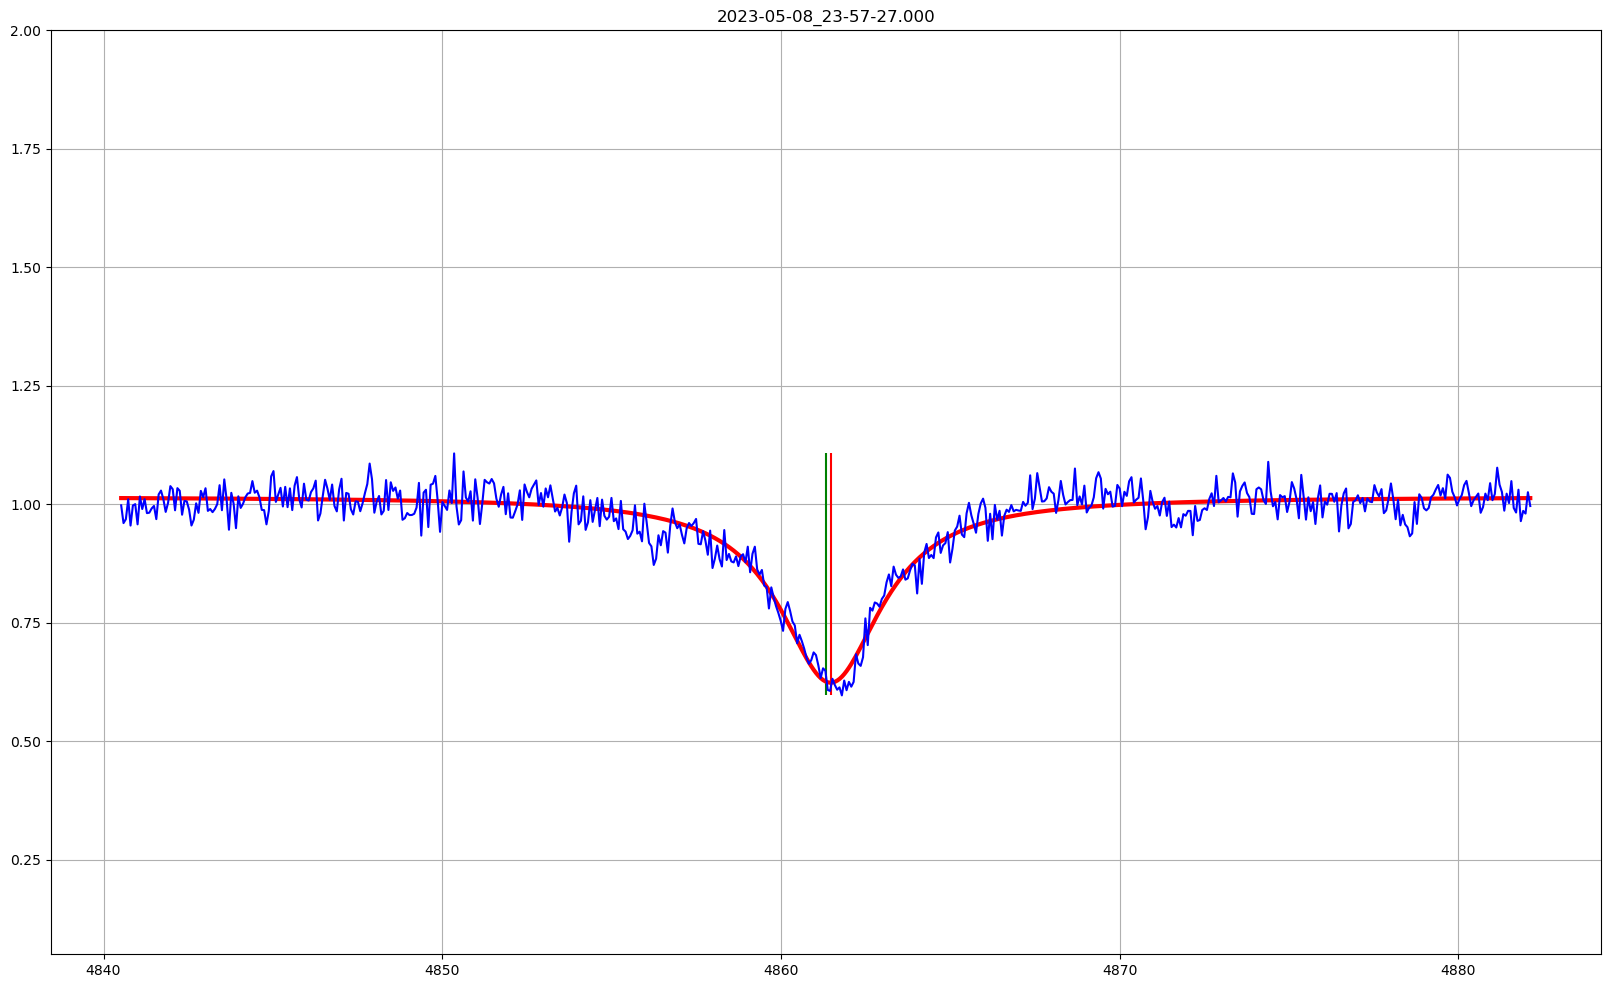

0


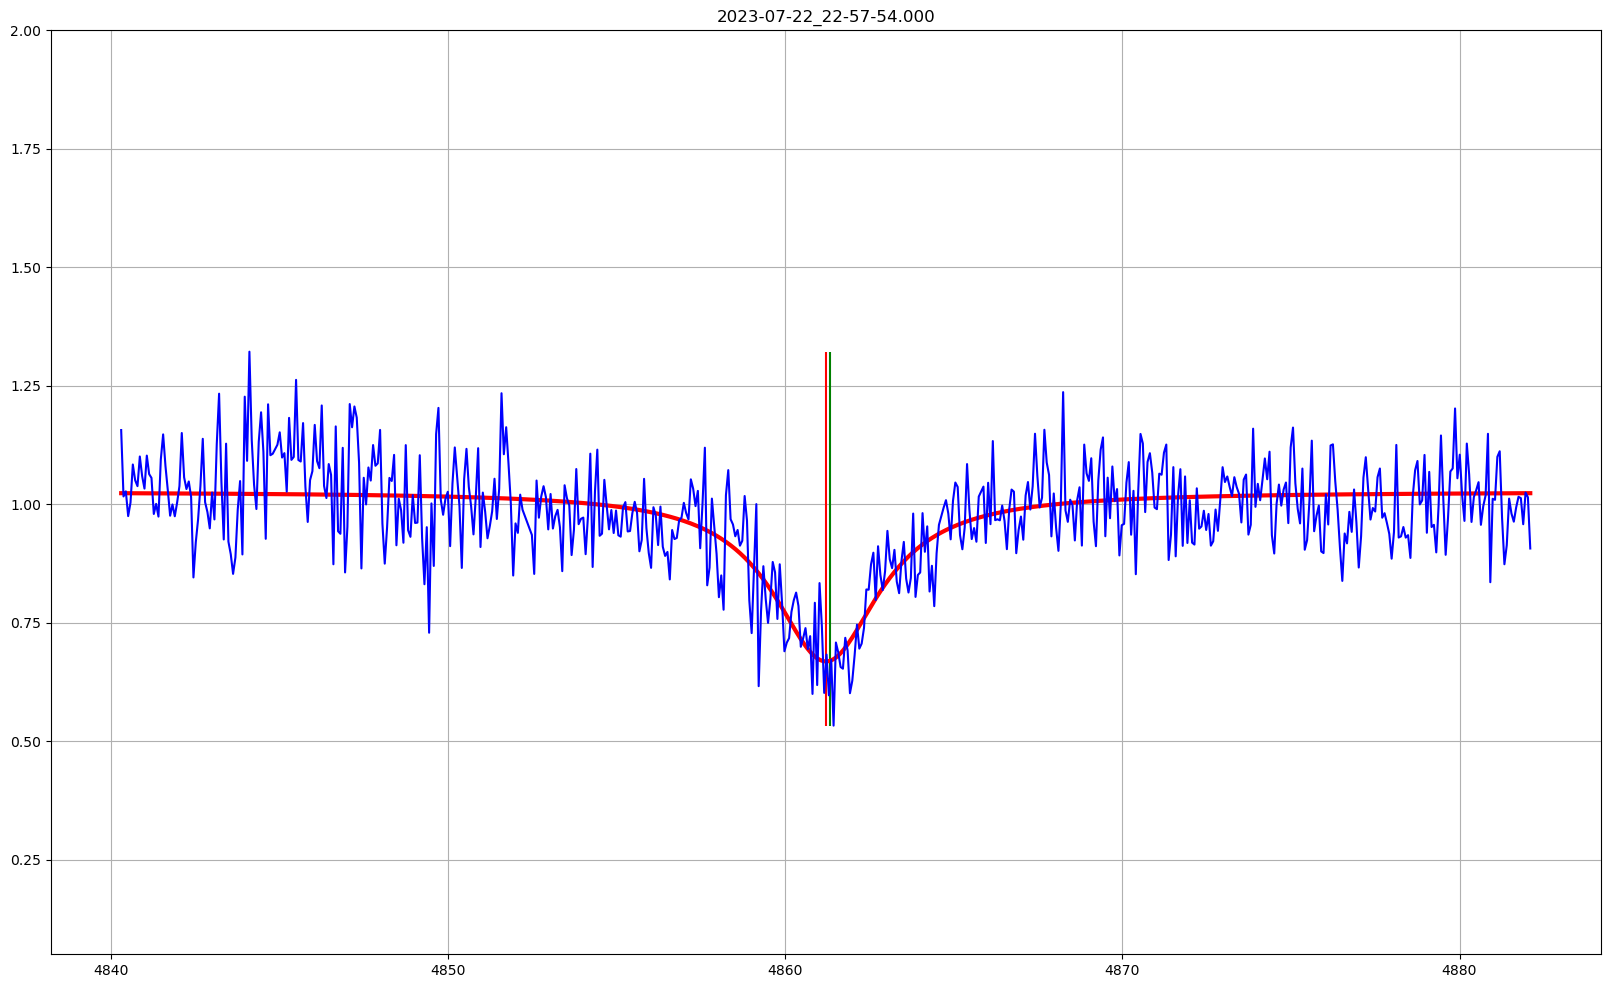

1


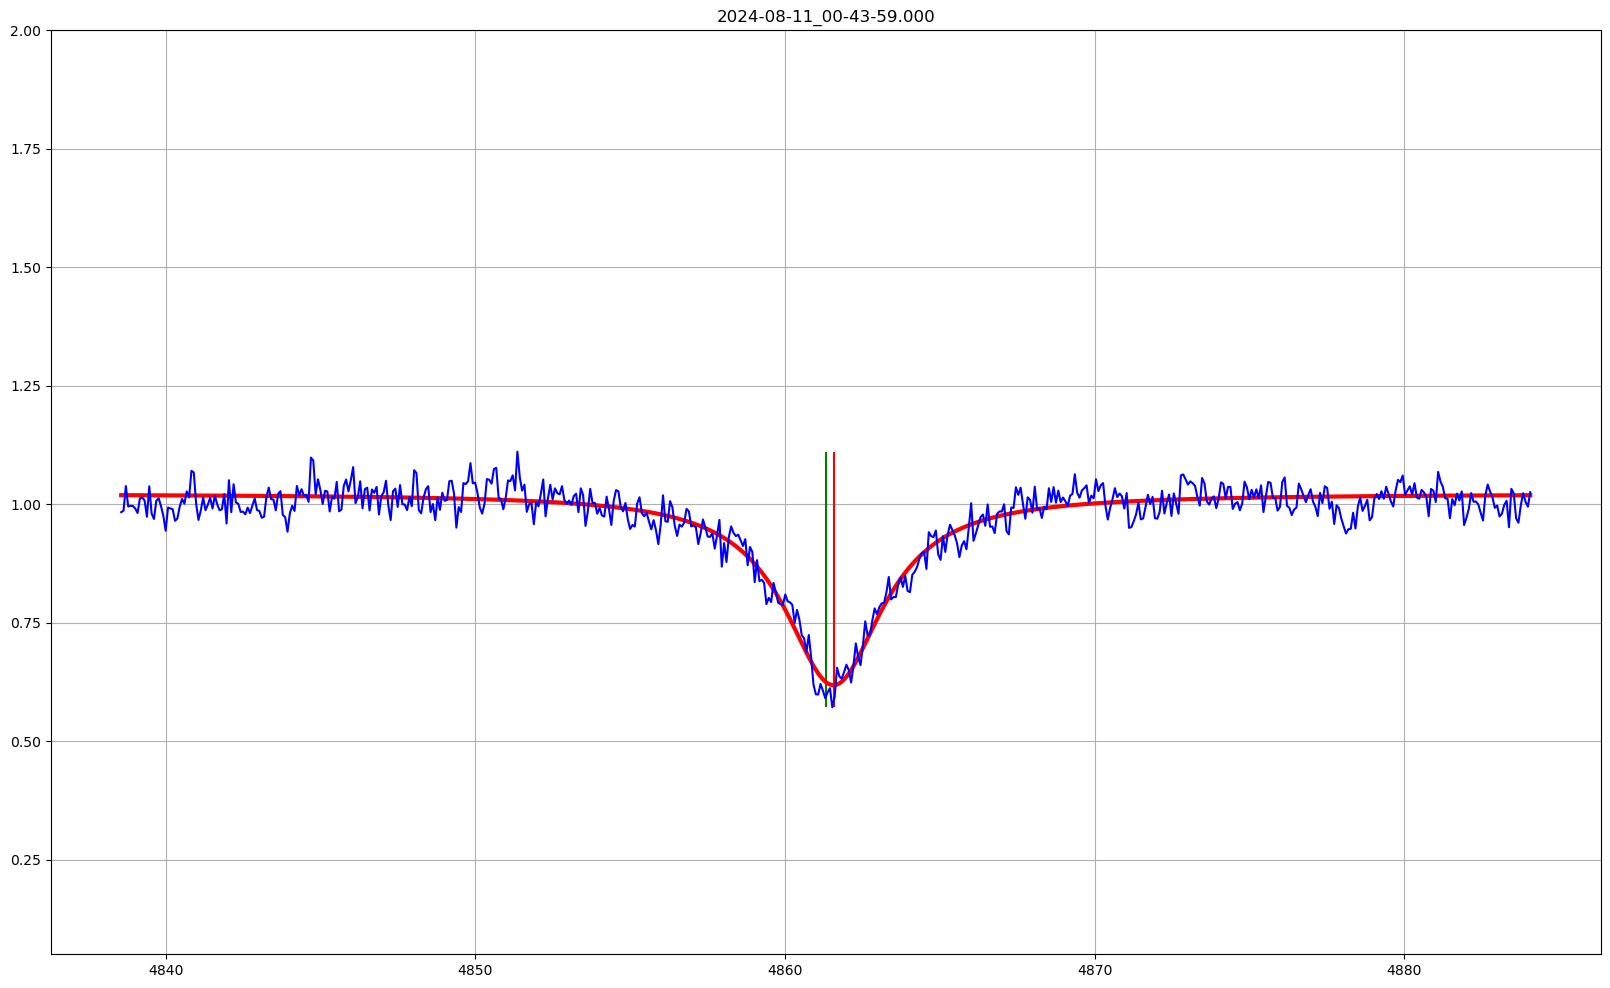

2


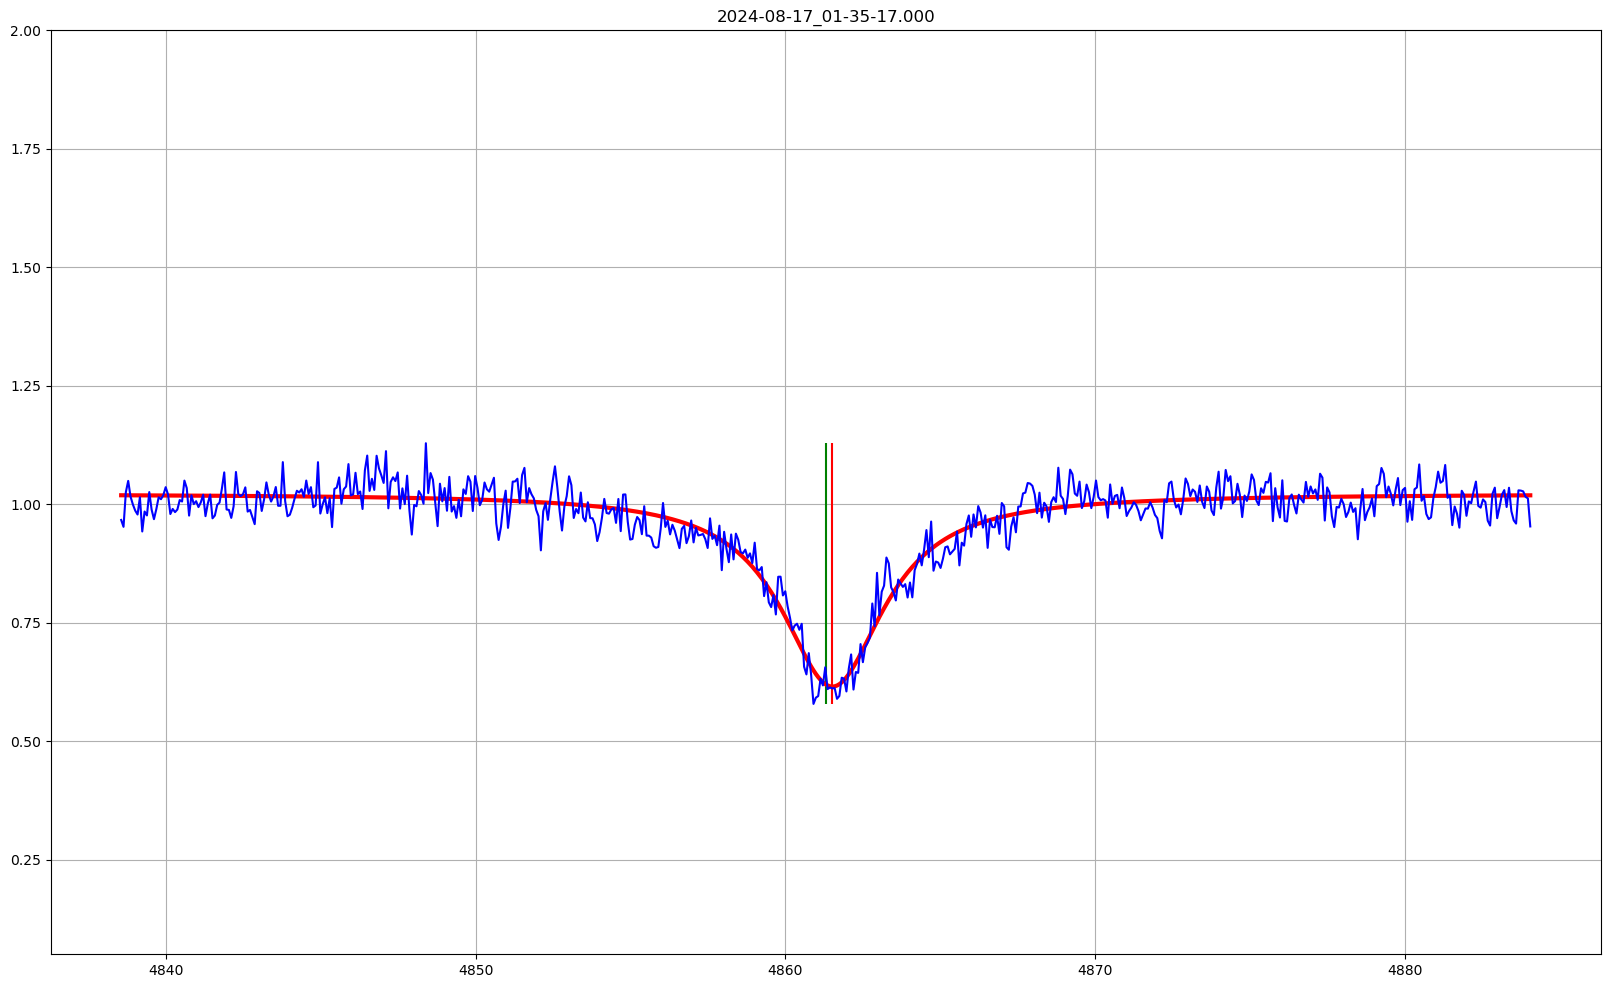

3


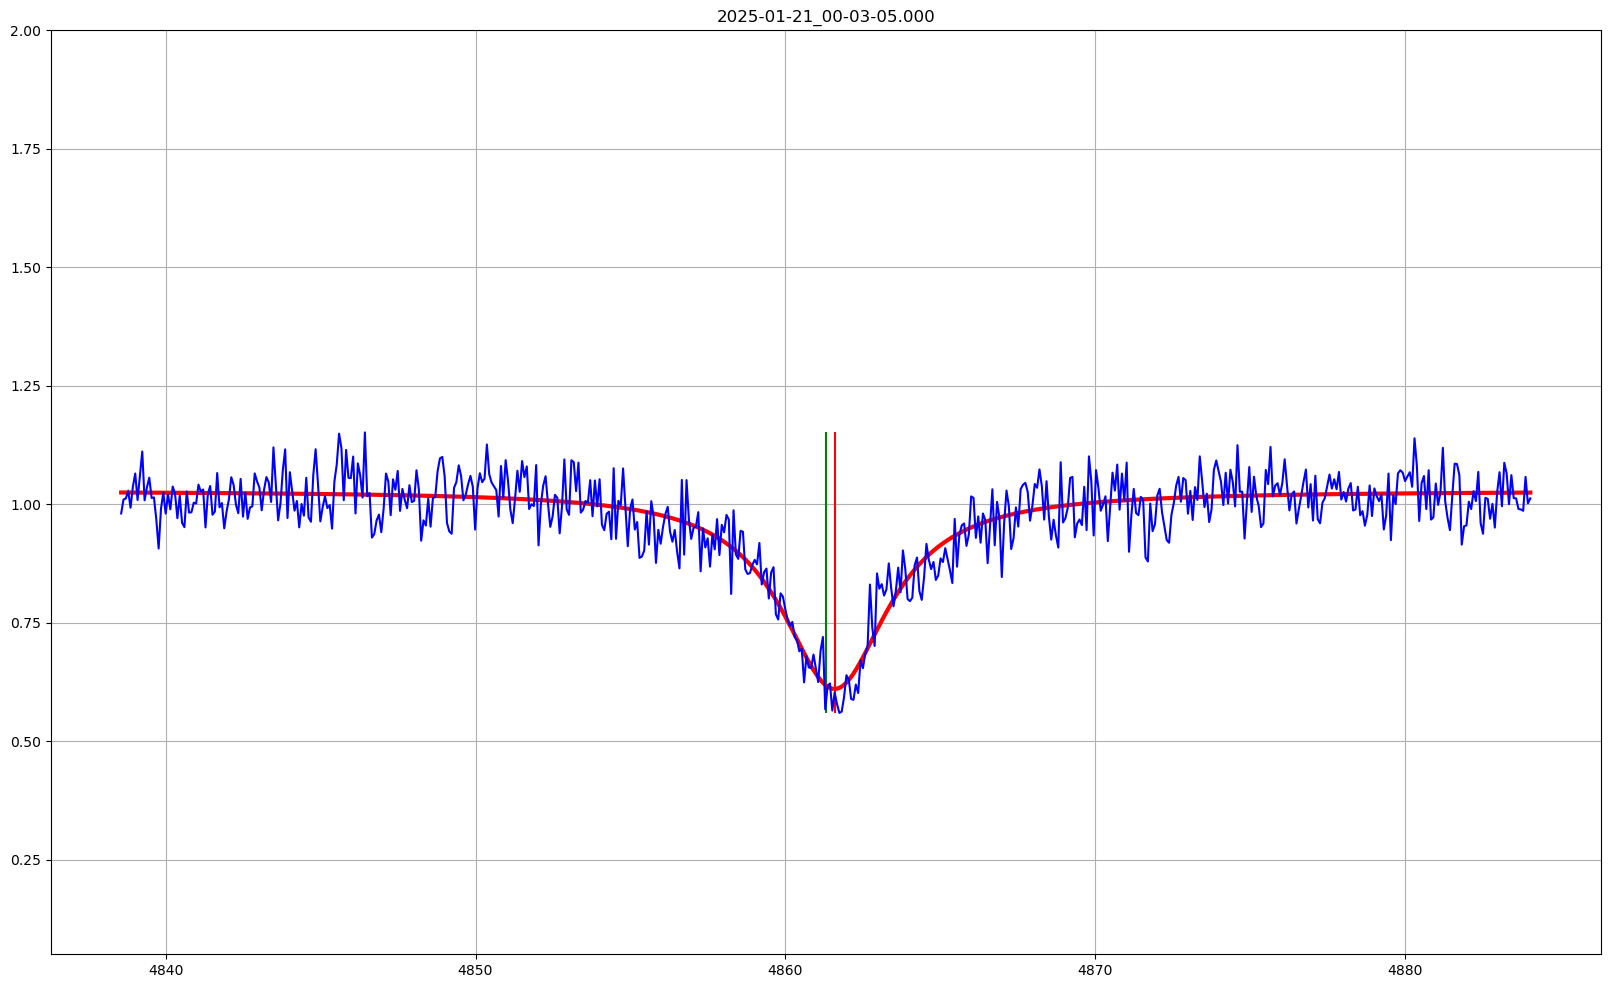

4


In [7]:
#UV

plot = 3#'all'

linien_UV = [3970.07, 4101.73, 4340.46, 4861.32] #4541.59, 
fit_windows = [(20,20), (10, 10), (20, 20), (20, 20)]
peaks_UV = []
time_index = 0
for wave, flux in zip(UV_wave, UV_flux):
    new_wave = []
    new_flux = []
    fit_args = []

    plot_window = 300
    for i, linie in enumerate(linien_UV):
        
        index_lower = find_nearest(wave, linie-fit_windows[i][0])
        index_higher = find_nearest(wave, linie+fit_windows[i][1])
        index = find_nearest(wave, linie)

        fit_region_wave = wave[index_lower:index_higher]
        fit_region_flux = flux[index_lower:index_higher]
        plot_region_wave = wave[index-plot_window:index+plot_window]
        plot_region_flux = flux[index-plot_window:index+plot_window]
        new_wave.append(plot_region_wave)
        new_flux.append(plot_region_flux)
       
        p0 = [linie, 1, 0, 1, 1]
        bounds = ([fit_region_wave[0], 0, 0, 0, 0.95], [fit_region_wave[-1], np.inf, np.inf, np.inf, 1.05])
        
        arg, corr = curve_fit(voigt_pro, fit_region_wave, fit_region_flux, p0=p0, bounds=bounds, method ='trf')
        fit_args.append(arg)
        
    if plot == 'all':
        plt.figure(figsize=(20,12))
        for index, linie in enumerate(linien_UV):
            plt.vlines(linie, min(new_flux[index]), max(new_flux[index]), color ='b')
            plt.vlines(fit_args[index][0], min(new_flux[index]), max(new_flux[index]), color ='r')
            plt.plot(new_wave[index], voigt_pro(new_wave[index], *fit_args[index]), linewidth = 3, color ='r')
            plt.scatter(new_wave[index], new_flux[index], s=3, c='b')
        plt.ylim(np.min(new_flux)-0.05, 2)
        plt.title(f'{time_list_UV[time_index]}')
        plt.show()
        
    else:
        plt.figure(figsize=(20,12))
        linie = linien_UV[plot]
        plt.vlines(linie, min(new_flux[plot]), max(new_flux[plot]), color ='g')
        plt.vlines(fit_args[plot][0], min(new_flux[plot]), max(new_flux[plot]), color ='r')
        plt.plot(new_wave[plot], voigt_pro(new_wave[plot], *fit_args[plot]), linewidth = 3, color ='r')
        plt.plot(new_wave[plot], new_flux[plot], c='b')
        plt.ylim(0.05, 2)
        plt.title(f'{time_list_UV[time_index]}')
        plt.grid()
        plt.show()
    print(time_index)
    time_index += 1
    spec_peaks = []
    for arg in fit_args:
        spec_peaks.append(arg[0])    
    peaks_UV.append(spec_peaks)

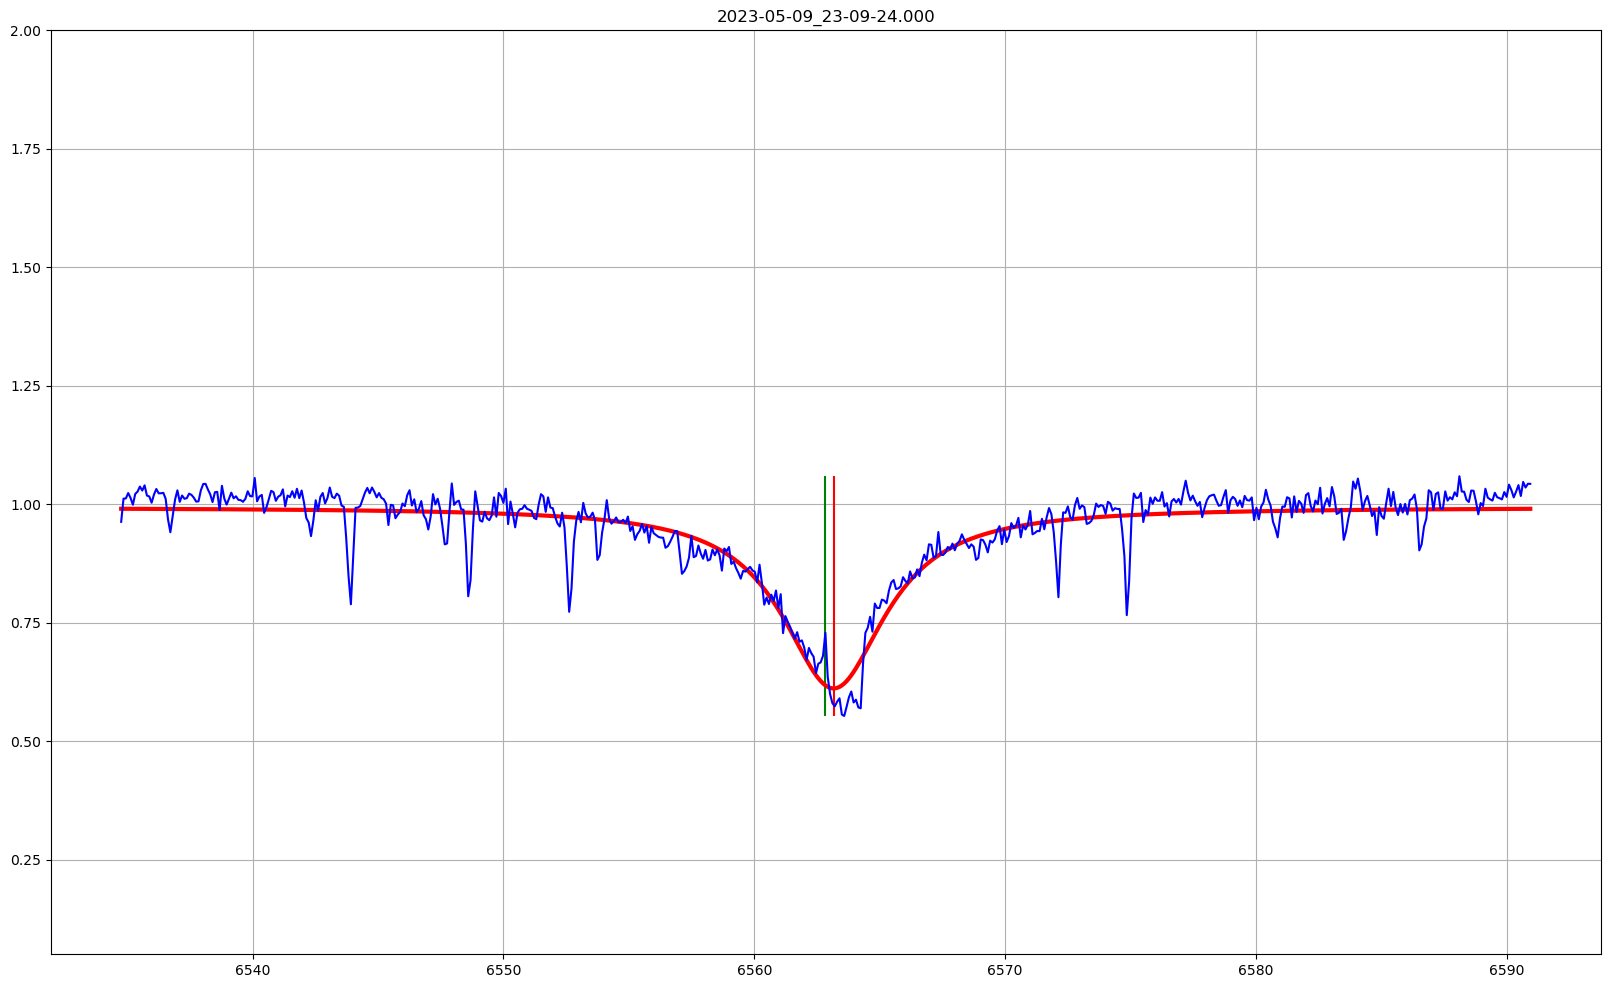

0


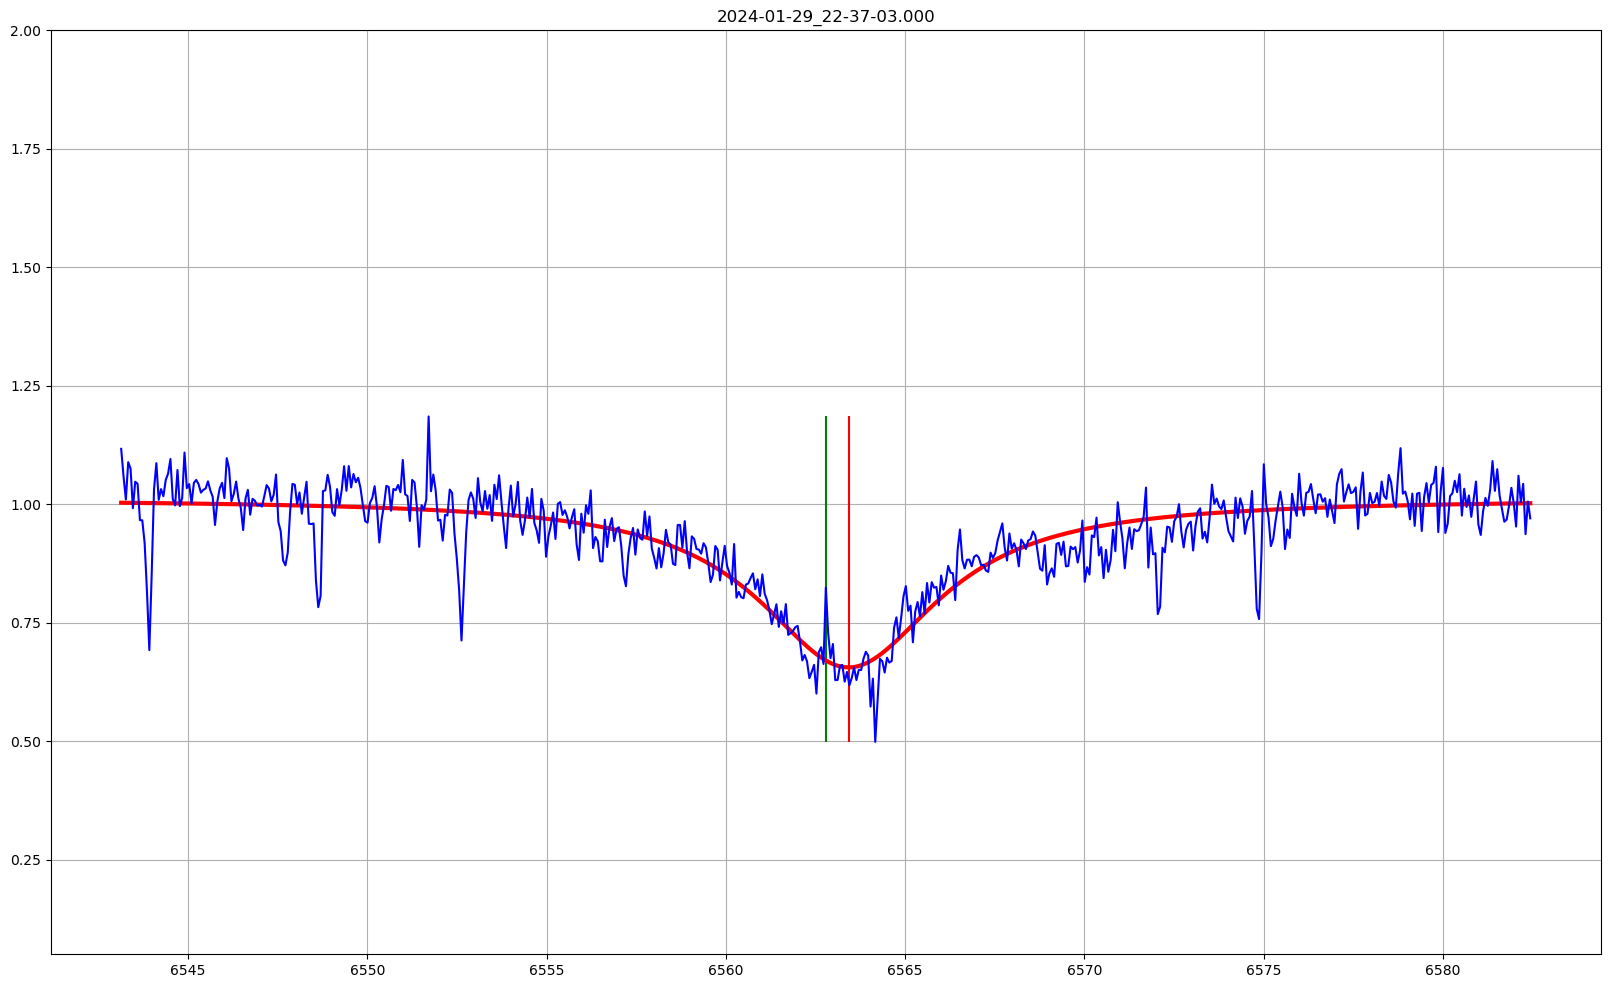

1


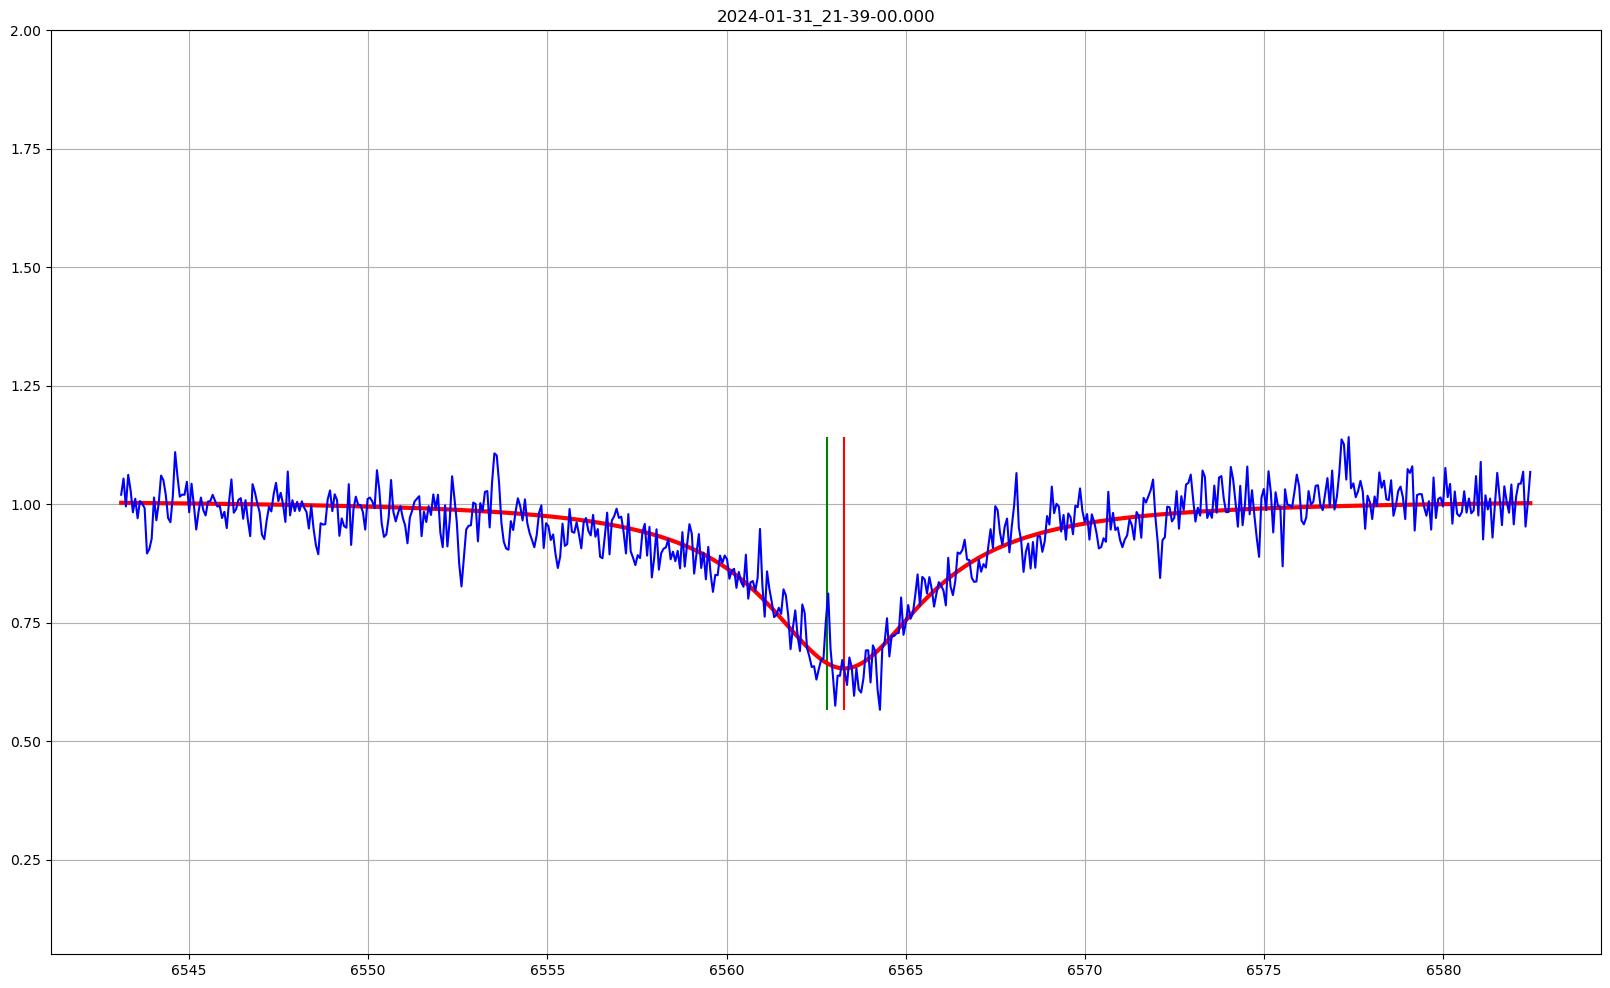

2


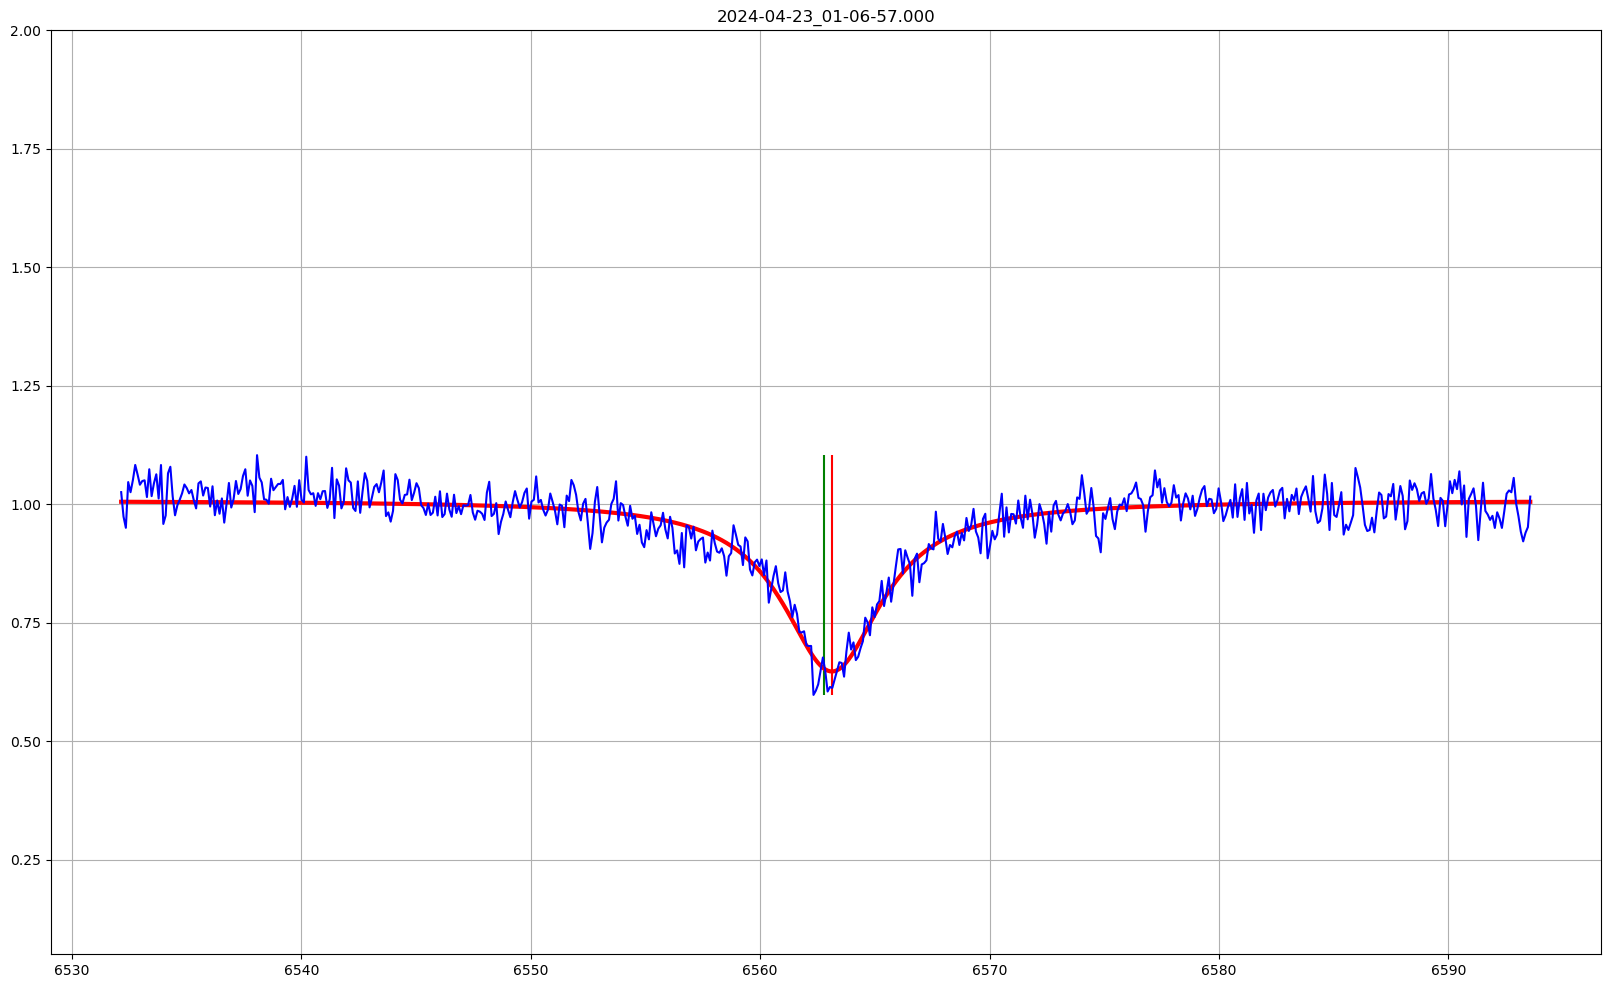

3


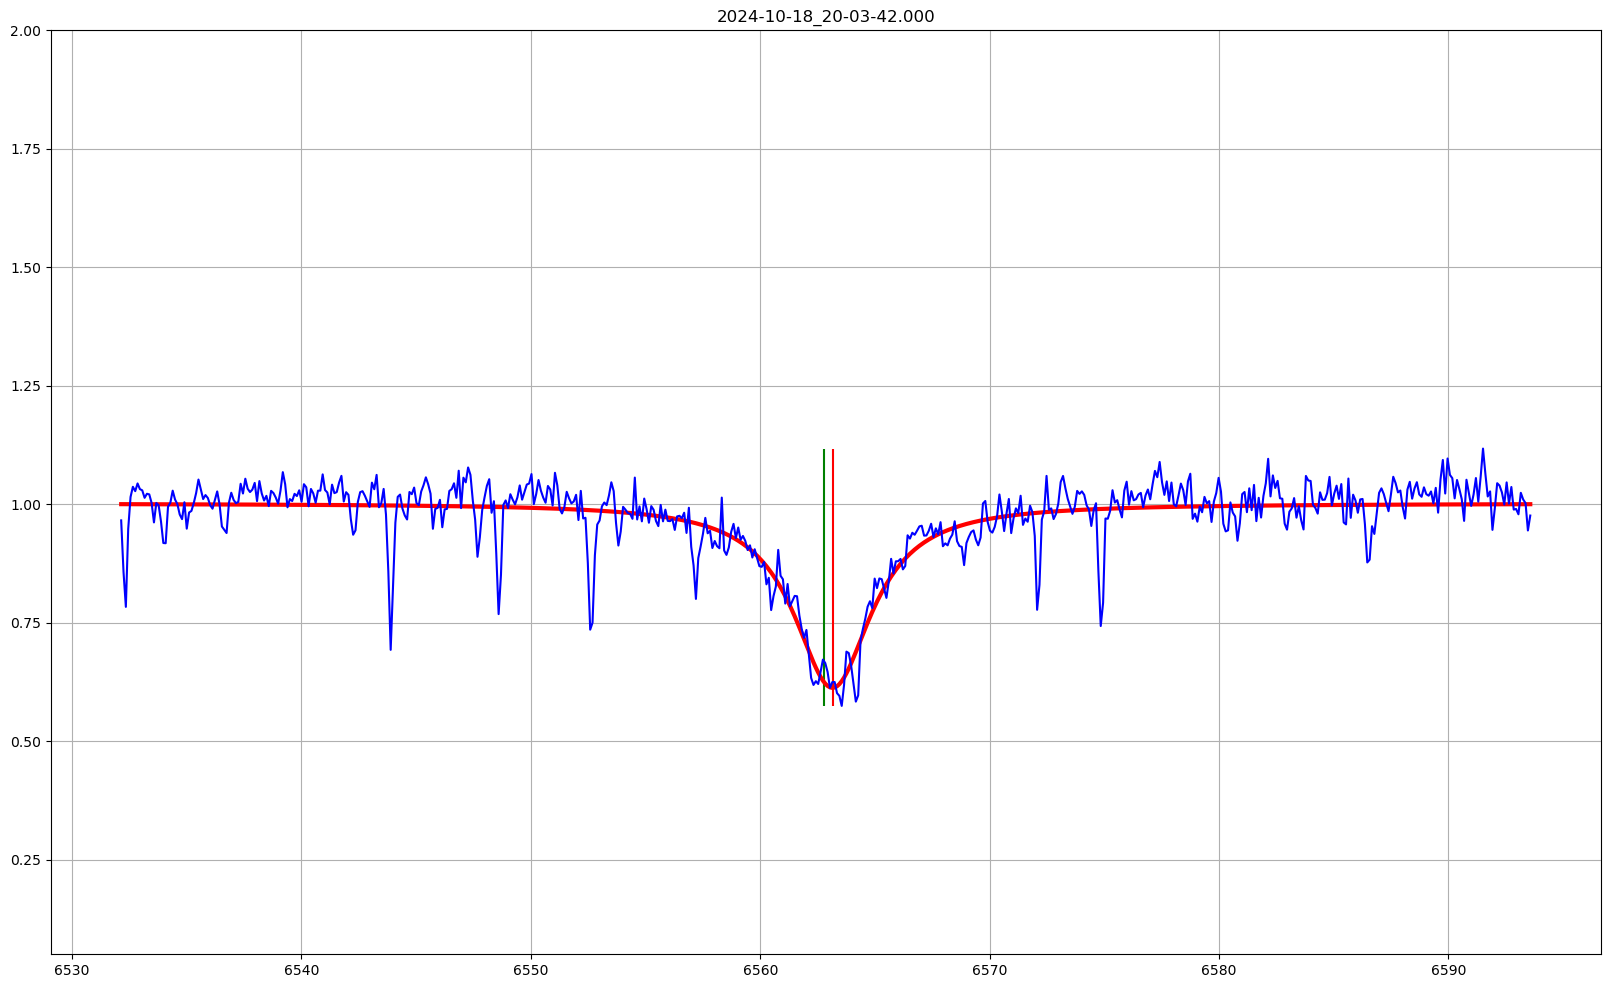

4


In [8]:
#VIS

plot = 1#'all'

linien_VIS = [4861.32, 6562.80]
fit_windows = [(20,20), (20, 20)]
peaks_VIS = []
time_index = 0
for wave, flux in zip(VIS_wave, VIS_flux):
    new_wave = []
    new_flux = []
    fit_args = []

    plot_window = 300
    for i, linie in enumerate(linien_VIS):
        
        index_lower = find_nearest(wave, linie-fit_windows[i][0])
        index_higher = find_nearest(wave, linie+fit_windows[i][1])
        index = find_nearest(wave, linie)

        fit_region_wave = wave[index_lower:index_higher]
        fit_region_flux = flux[index_lower:index_higher]
        plot_region_wave = wave[index-plot_window:index+plot_window]
        plot_region_flux = flux[index-plot_window:index+plot_window]
        new_wave.append(plot_region_wave)
        new_flux.append(plot_region_flux)
       
        p0 = [linie, 1, 0, 1, 1]
        bounds = ([fit_region_wave[0], 0, 0, 0, 0.95], [fit_region_wave[-1], np.inf, np.inf, np.inf, 1.05])
        
        arg, corr = curve_fit(voigt_pro, fit_region_wave, fit_region_flux, p0=p0, bounds=bounds, method ='trf')
        fit_args.append(arg)
        
    if plot == 'all':
        plt.figure(figsize=(20,12))
        for index, linie in enumerate(linien_VIS):
            plt.vlines(linie, min(new_flux[index]), max(new_flux[index]), color ='b')
            plt.vlines(fit_args[index][0], min(new_flux[index]), max(new_flux[index]), color ='r')
            plt.plot(new_wave[index], voigt_pro(new_wave[index], *fit_args[index]), linewidth = 3, color ='r')
            plt.scatter(new_wave[index], new_flux[index], s=3, c='b')
        plt.ylim(np.min(new_flux)-0.05, 2)
        plt.title(f'{time_list_VIS[time_index]}')
        plt.show()
        
    else:
        plt.figure(figsize=(20,12))
        linie = linien_VIS[plot]
        plt.vlines(linie, min(new_flux[plot]), max(new_flux[plot]), color ='g')
        plt.vlines(fit_args[plot][0], min(new_flux[plot]), max(new_flux[plot]), color ='r')
        plt.plot(new_wave[plot], voigt_pro(new_wave[plot], *fit_args[plot]), linewidth = 3, color ='r')
        plt.plot(new_wave[plot], new_flux[plot], c='b')
        plt.ylim(0.05, 2)
        plt.title(f'{time_list_VIS[time_index]}')
        plt.grid()
        plt.show()
    print(time_index)
    time_index += 1
    spec_peaks = []
    for arg in fit_args:
        spec_peaks.append(arg[0])    
    peaks_VIS.append(spec_peaks)

In [9]:
print(np.array(peaks_UV))
result = []
for index in range(len(peaks_UV)):
    result.append((np.array(peaks_UV[index])-np.array(linien_UV))/np.array(linien_UV))
print(np.nanmean(np.array(result), axis = 1), np.nanstd(np.array(result), axis = 1))

print(np.array(peaks_VIS))
result = []
for index in range(len(peaks_VIS)):
    result.append((np.array(peaks_VIS[index])-np.array(linien_VIS))/np.array(linien_VIS))
print(np.nanmean(np.array(result), axis = 1), np.nanstd(np.array(result), axis = 1))

[[3970.03470478 4101.86212138 4340.65724029 4861.46418557]
 [3969.01716548 4102.03846089 4340.36909994 4861.20434747]
 [3970.15329771 4101.87117554 4340.7404453  4861.56487087]
 [3969.20379776 4101.91652719 4340.68477866 4861.52036181]
 [3967.49505271 4102.05064345 4340.65525158 4861.59427196]]
[ 2.46057050e-05 -5.86807889e-05  4.25957783e-05 -1.99263804e-05
 -1.17253462e-04] [2.02455673e-05 1.25711533e-04 1.64257041e-05 1.14525348e-04
 3.06998791e-04]
[[4861.44179722 6563.16164778]
 [4861.62065996 6563.42375191]
 [4861.64620896 6563.28586054]
 [4861.57999436 6563.13030915]
 [4861.41565664 6563.15006158]]
[4.00800326e-05 7.84454781e-05 7.05677336e-05 5.19063894e-05
 3.65086849e-05] [1.50256810e-05 1.65980873e-05 3.46477353e-06 1.57586729e-06
 1.68315929e-05]


In [10]:
#(time_index, peak_index)
to_delete_UV = [(4, 0), (1, 0), (3,0)] #(0,0)  (1,2), (3,2), (4,2)
to_delete_VIS = []

def calc_shift_and_error(peaks, linien, to_delete):
    peaks = np.array(peaks)
    for x, y in to_delete:
        peaks[x, y] = np.nan
    result = []
    for index in range(len(peaks)):
        result.append((np.array(peaks[index])-np.array(linien))/np.array(linien))
    return np.nanmean(np.array(result), axis = 1), np.nanstd(np.array(result), axis = 1)

In [11]:
shifts = np.ones(len(time_list))
errors = np.ones(len(time_list))

shifts_UV, errors_UV = calc_shift_and_error(peaks_UV, linien_UV, to_delete_UV)
shifts_VIS, errors_VIS = calc_shift_and_error(peaks_VIS, linien_VIS, to_delete_VIS)

for shift, index in zip(shifts_UV, time_per_UV):
    shifts[index] = shift
for shift, index in zip(shifts_VIS, time_per_VIS):
    shifts[index] = shift
for error, index in zip(errors_UV, time_per_UV):
    errors[index] = error
for error, index in zip(errors_VIS, time_per_VIS):
    errors[index] = error


print(shifts)
print(errors)

print(list(zip(shifts_VIS, time_per_VIS)))
print(list(zip(shifts_UV, time_per_UV)))

[2.46057050e-05 4.00800326e-05 1.01565938e-05 7.84454781e-05
 7.05677336e-05 5.19063894e-05 4.25957783e-05 4.61591976e-05
 3.65086849e-05 5.98586826e-05]
[2.02455673e-05 1.50256810e-05 4.60091862e-05 1.65980873e-05
 3.46477353e-06 1.57586729e-06 1.64257041e-05 4.34273424e-06
 1.68315929e-05 1.37657575e-05]
[(4.008003260681366e-05, 1), (7.844547809454141e-05, 3), (7.056773362630526e-05, 4), (5.19063893909833e-05, 5), (3.6508684887519314e-05, 8)]
[(2.460570498573964e-05, 0), (1.015659376536651e-05, 2), (4.2595778348704995e-05, 6), (4.6159197601984684e-05, 7), (5.9858682624859364e-05, 9)]


299792458.0


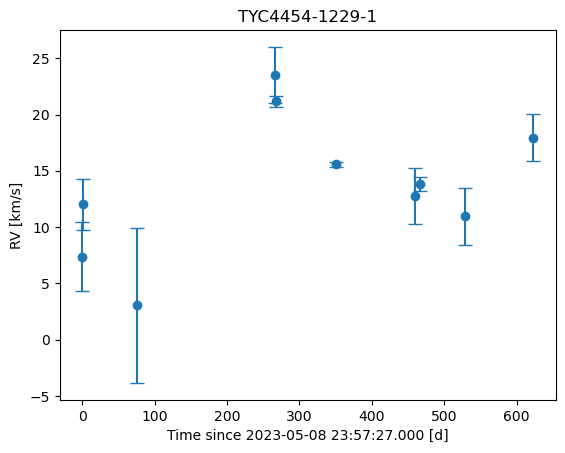

[ 7.37660478 12.01569149  3.04487021 23.5173627  21.15567432 15.56114406
 12.76989309 13.83817931 10.94502838 17.9451816 ]
[3.0347342  2.25229292 6.89660351 2.48799069 0.51935649 0.23621656
 2.4621511  0.65095949 2.52299231 2.06343514]


In [12]:
from scipy.constants import c
print(c)
x_values = [time.mjd for time in time_objects]
x_values -= x_values[0]

plt.errorbar(x_values, shifts*c/1000, yerr = errors*c/2/1000, marker='o', linestyle='none', capsize=5)
#plt.errorbar(x_values, (shifts-shifts[0])*c/1000, yerr = np.array(errors)*c/2/1000, marker='o', linestyle='none', capsize=5)
#plt.scatter(x_values, np.array(shifts)*c/1000)
plt.xlabel(f'Time since {time_objects[0].iso} [d]')
plt.ylabel('RV [km/s]')
plt.title('TYC4454-1229-1')
plt.show()
print((shifts)*c/1000)
print(errors*c/2/1000)

In [13]:
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import SkyCoord, ICRS

tls = EarthLocation(lat="50d58m48.5s", lon="11d42m40.2s", height= "341m")
sc = SkyCoord(ICRS(ra= "20d 03m 46.2988110984s" , dec= "+71d 36m 24.008762196s"), distance = 290.158 * u.pc)

middle_time_list = []
for datafile_path in datafile_path_list:
    path = datafile_path[:-4]+'/fit_data/obj_raw.fits'
    middle_time_list.append(extract_middle_time(path))

barycentric_correction_list = []
x_values = []
for time in middle_time_list:
    barycentric_correction_list.append(sc.radial_velocity_correction(obstime = time, location = tls).value)
    x_values.append(time+time.light_travel_time(sc, kind='barycentric', location=tls, ephemeris = 'de432s'))
x_values_jd = []
for time in x_values:
    x_values_jd.append((time - x_values[0]).jd)
    
bary_corr = np.array(barycentric_correction_list)
print(bary_corr)

[ -3133.48874256  -2872.1789919   14586.30255972 -16094.31987731
 -16278.49618558  -7206.17449519  16349.05025773  16509.57263762
   8849.84410936 -15130.37249958]


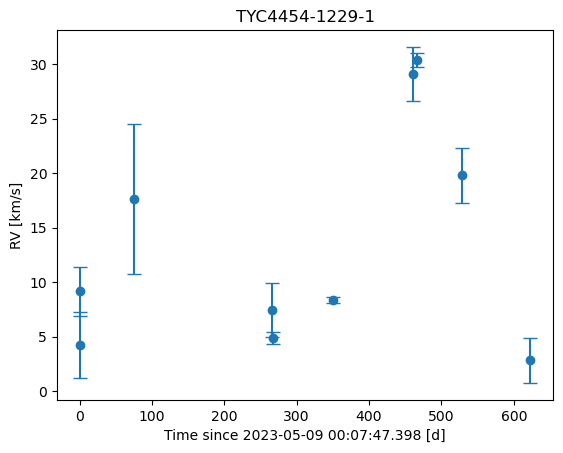

[ 4.24311604  9.1435125  17.63117277  7.42304282  4.87717813  8.35496957
 29.11894335 30.34775195 19.79487249  2.8148091 ]
[3.0347342  2.25229292 6.89660351 2.48799069 0.51935649 0.23621656
 2.4621511  0.65095949 2.52299231 2.06343514]


In [14]:

plt.errorbar(x_values_jd, (shifts*c+bary_corr)/1000, yerr = errors*c/2/1000, marker='o', linestyle='none', capsize=5)
#plt.errorbar(x_values, (shifts-shifts[0])*c/1000, yerr = np.array(errors)*c/2/1000, marker='o', linestyle='none', capsize=5)
#plt.scatter(x_values, np.array(shifts)*c/1000)
plt.xlabel(f'Time since {x_values[0].iso} [d]')
plt.ylabel('RV [km/s]')
plt.title('TYC4454-1229-1')
plt.show()
print((shifts*c+bary_corr)/1000)
print(errors*c/2/1000)

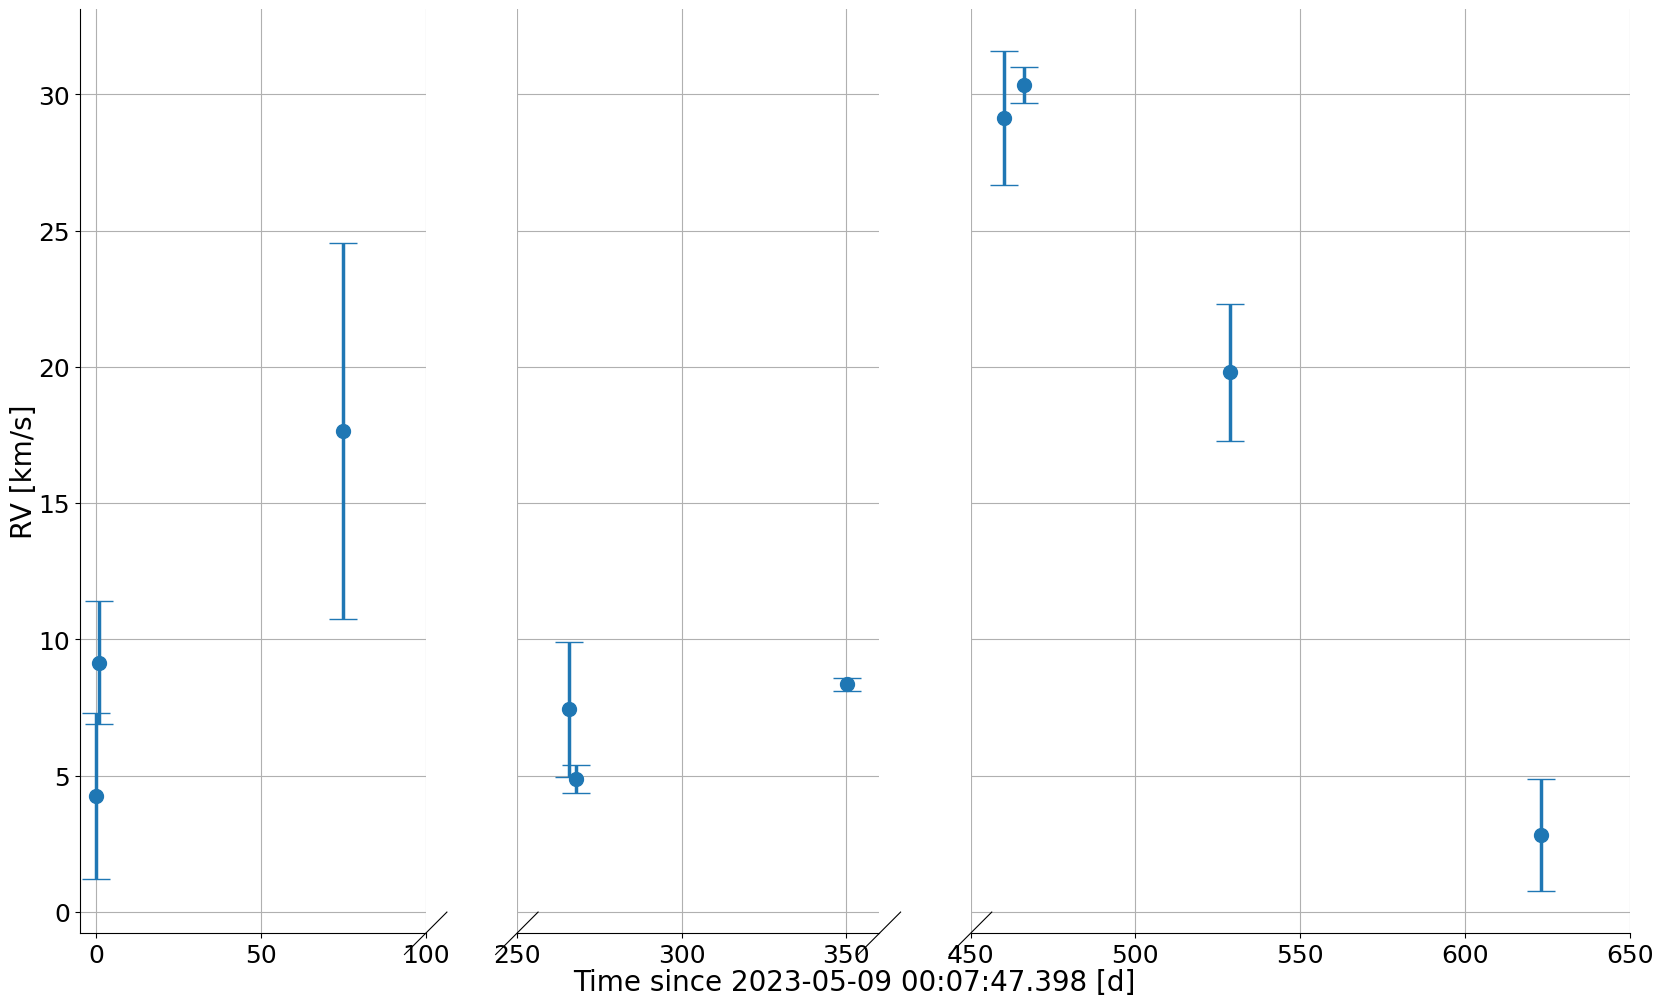

13.374936870775679


In [15]:
from brokenaxes import brokenaxes

fig = plt.figure(figsize=(20,12))
bax = brokenaxes(xlims=((-5,100), (250, 360), (450, 650)),
                 subplot_spec=fig.add_gridspec(1,1)[0])


bax.errorbar(x_values_jd, (shifts*c+bary_corr)/1000, yerr = errors*c/2/1000, marker='o', linestyle='none', capsize=10, markersize=10, lw=2.5)
#plt.title('TYC4454-1229-1')
bax.set_xlabel(f'Time since {x_values[0].iso} [d]', labelpad=25, fontsize=20)
bax.set_ylabel('RV [km/s]', fontsize=20)
bax.tick_params(axis='both', labelsize=18)  # Erhöht die Schriftgröße der Ticklabels
bax.grid()
plt.savefig('/home/birger/Schreibtisch/Bachelorarbeit/Bilder/TYC4454-1229-1.png')

plt.show()
print(np.mean((shifts*c+bary_corr)/1000))

In [16]:
index_UV= 1
index_VIS=1
print((np.array(peaks_UV[index_UV])-np.array(linien_UV))/np.array(linien_UV))
print((np.array(peaks_VIS[index_VIS])-np.array(linien_VIS))/np.array(linien_VIS))

[-2.65192937e-04  7.52026313e-05 -2.09424957e-05 -2.37903543e-05]
[6.18473908e-05 9.50435654e-05]


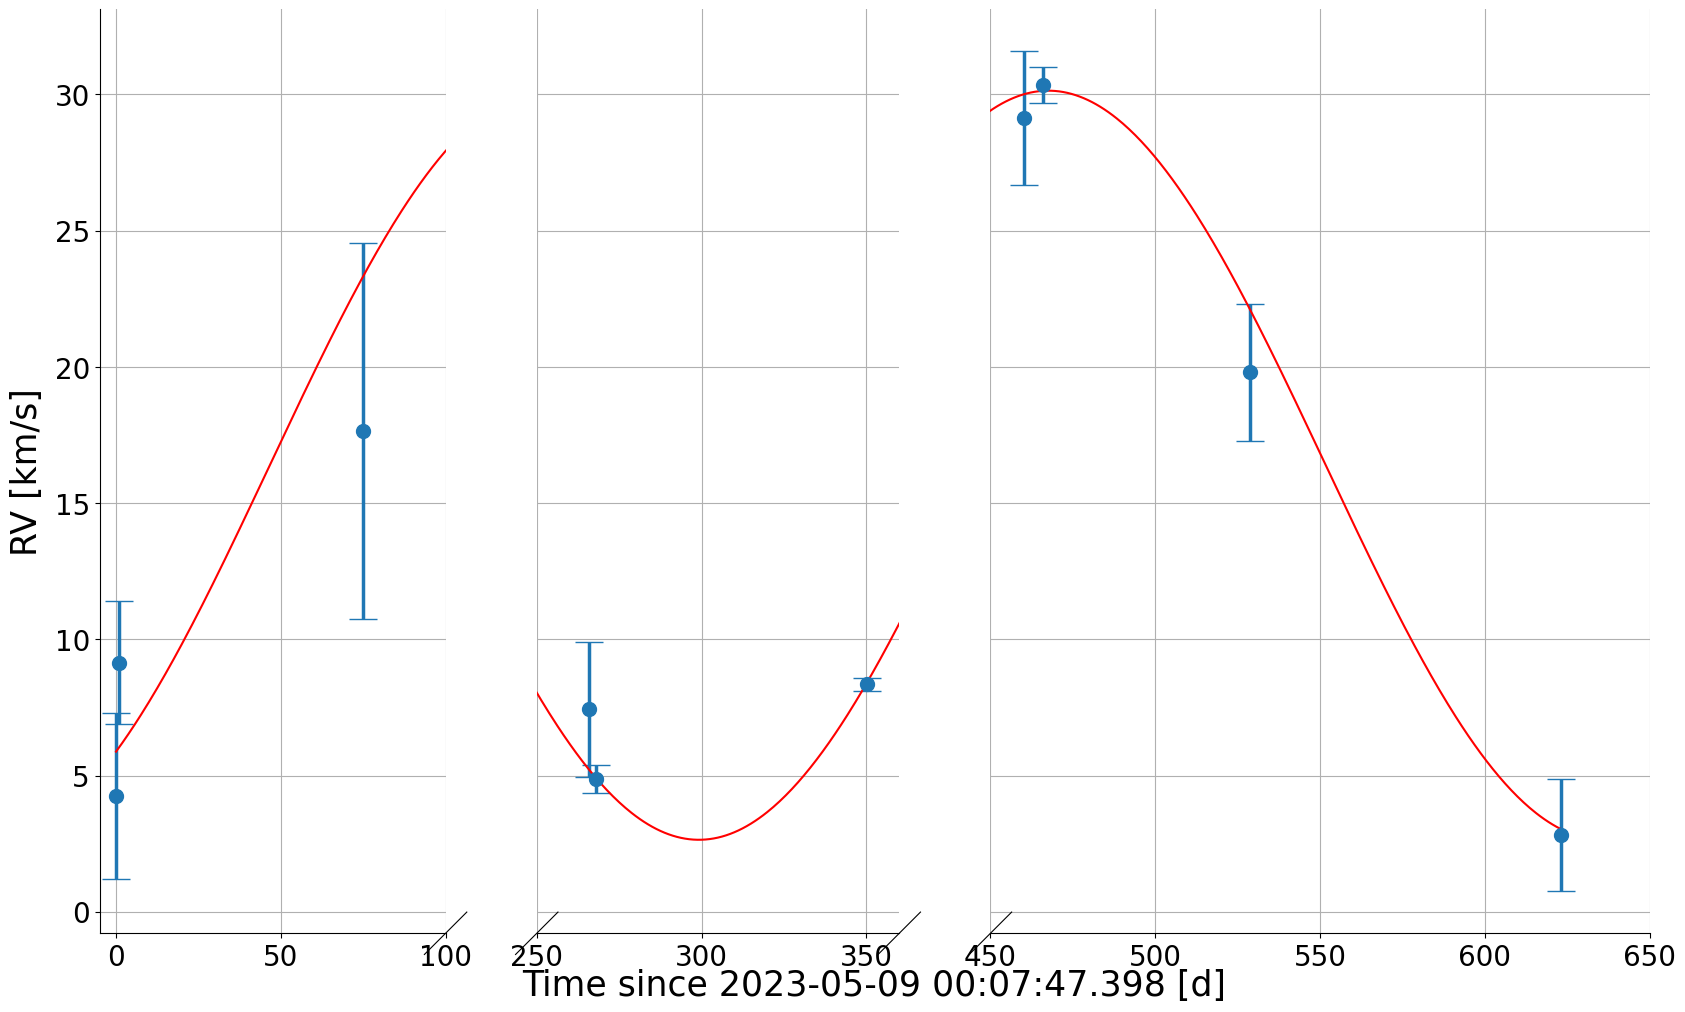

Period = 336.724407254331


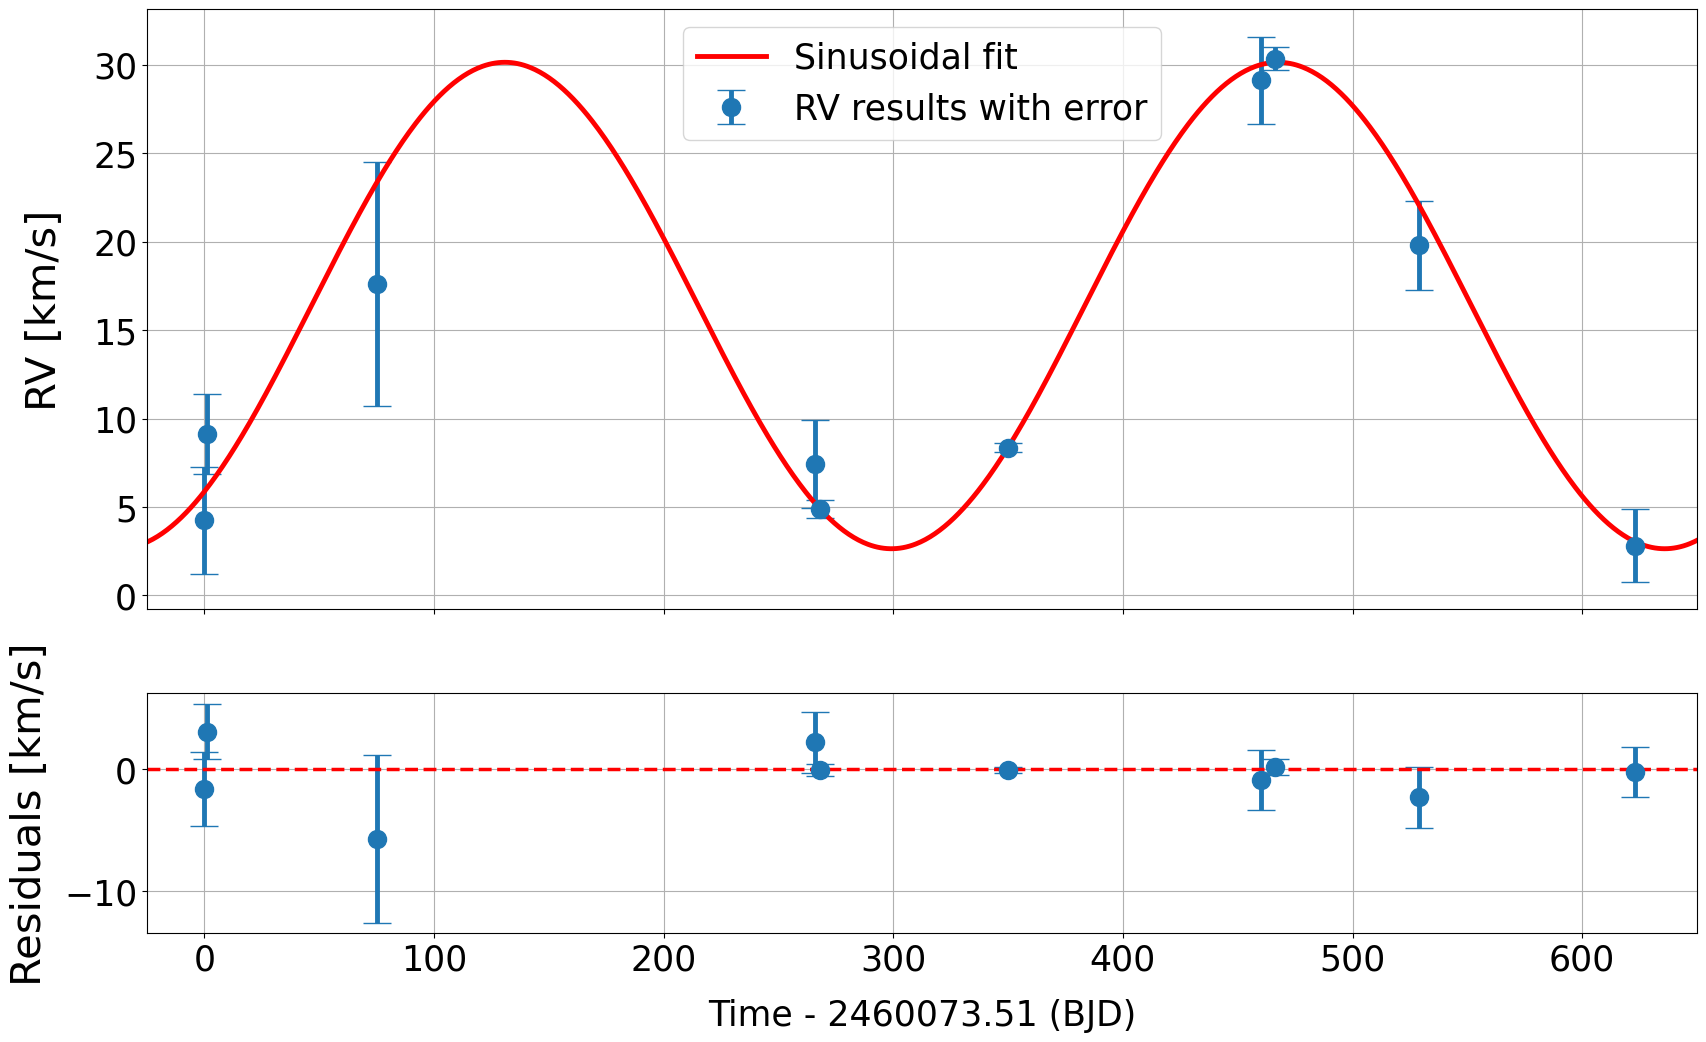

[ 4.24311604  9.1435125  17.63117277  7.42304282  4.87717813  8.35496957
 29.11894335 30.34775195 19.79487249  2.8148091 ]
[3.0347342  2.25229292 6.89660351 2.48799069 0.51935649 0.23621656
 2.4621511  0.65095949 2.52299231 2.06343514]


In [21]:
def sinusoidal(x, K, P, x_0, phi, gamma):
    return K*np.sin(2*np.pi/P*(x-x_0)+phi)+gamma

p0 = [30, 400, 1, 0, 20]

arg, corr = curve_fit(sinusoidal, x_values_jd, (shifts*c+bary_corr)/1000, sigma= errors*c/2/1000, p0=p0)

fig = plt.figure(figsize=(20,12))
bax = brokenaxes(xlims=((-5,100), (250, 360), (450, 650)),
                 subplot_spec=fig.add_gridspec(1,1)[0])
x= np.linspace(x_values_jd[0], x_values_jd[-1], 1000)

bax.errorbar(x_values_jd, (shifts*c+bary_corr)/1000, yerr = errors*c/2/1000, marker='o', linestyle='none', capsize=10, markersize=10, lw=2.5)
#plt.title('BD+75325')
bax.plot(x, sinusoidal(x, *arg), color='r')
bax.set_xlabel(f'Time since {x_values[0].iso} [d]', labelpad=25, fontsize=25)
bax.set_ylabel('RV [km/s]', fontsize=25, labelpad = 40)
bax.tick_params(axis='both', labelsize=20)  # Erhöht die Schriftgröße der Ticklabels
bax.grid()
plt.show()
print('Period =', arg[1])


from matplotlib import gridspec

y_fit = sinusoidal(x_values_jd, *arg)

res = (shifts*c+bary_corr)/1000 - y_fit

x= np.linspace(x_values_jd[0]-35, x_values_jd[-1]+35, 1000)

fig = plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(2, 1, height_ratios =(5,2))
ax0 = plt.subplot(gs[0])
ax0.errorbar(x_values_jd, (shifts*c+bary_corr)/1000, yerr = errors*c/2/1000, marker='o', linestyle='none', capsize=10, markersize=13, lw=3.5, label='RV results with error')
ax0.plot(x, sinusoidal(x, *arg), color='r', label='Sinusoidal fit', lw=3.5)

#plt.errorbar(x_values, (shifts-shifts[0])*c/1000, yerr = np.array(errors)*c/2/1000, marker='o', linestyle='none', capsize=5)
#plt.scatter(x_values, np.array(shifts)*c/1000)
ax0.set_ylabel('RV [km/s]', labelpad=20, fontsize=30)
ax0.tick_params(labelbottom=False, labelsize=25)
ax0.set_xlim(-25,650)
#plt.title('TYC4454-1229-1')
ax0.grid()
ax0.legend(fontsize=25)

ax1= plt.subplot(gs[1])
ax1.errorbar(x_values_jd, res, yerr = errors*c/2/1000, marker='o', linestyle='none', capsize=10, markersize=13, lw=3.5, label='RV results with errors')
ax1.hlines(0, xmin=min(x)-30, xmax=max(x)+30, colors='red', linestyles='dashed', linewidth=2.5)  # Null-Linie
ax1.set_xlabel(f'Time - {x_values[0].jd:.2f} (BJD)', labelpad=15, fontsize=25)
ax1.set_ylabel("Residuals [km/s]", labelpad=10, fontsize=30)
ax1.set_xlim(-25,650)
ax1.tick_params(axis='both', labelsize=25)  # Erhöht die Schriftgröße der Ticklabels

ax1.grid()

plt.savefig('/home/birger/Schreibtisch/Bachelorarbeit/Bilder/TYC4454-1229-1_fit.png')
plt.show()
print((shifts*c+bary_corr)/1000)
print(errors*c/2/1000)

In [18]:


object_name = datafile_path_list[0][datafile_path_list[0].index(':')+1:datafile_path_list[0].index('/20')]
slit_table = []
middle_time_list = []
for datafile_path in datafile_path_list:
    path = datafile_path[:-4]+'/fit_data/obj_raw.fits'
    slit_table.append(fits.open(path)[0].header['CO-SLIT'])
    middle_time_list.append(extract_middle_time(path))

time_table = []
for time in middle_time_list:
    time_table.append(f'{(time+time.light_travel_time(sc, kind='barycentric', location=tls, ephemeris = 'de432s')).jd:.4f}')

grism_table = []
for i in range(len(time_table)):
    if i in time_per_UV:
        grism_table.append('UV')
    if i in time_per_VIS:
        grism_table.append('VIS')

values_table = [f'{shift:.2f}' for shift in (shifts*c+bary_corr)/1000]

errors_table = [fr'$\pm${error:.2f}' for error in errors * c / 2 / 1000]

data = dict(zip(time_table, zip(values_table, errors_table, grism_table, slit_table)))
df = pd.DataFrame(data, index = ['RV [km/s]', 'errors [km/s]', 'grism', 'slit width']).T
df.index.name = 'Time [BJD]'
df = df.reset_index()
latex_str = df.to_latex(index=False, caption=f'RV results for {object_name}.', label=f'tab:{object_name}')
print(latex_str)
with open('latex_table.txt', 'w') as f:
    f.write(latex_str)

\begin{table}
\caption{RV results for TYC4454-1229-1.}
\label{tab:TYC4454-1229-1}
\begin{tabular}{lllll}
\toprule
Time [BJD] & RV [km/s] & errors [km/s] & grism & slit width \\
\midrule
2460073.5054 & 4.24 & $\pm$3.03 & UV & 0.90mm \\
2460074.4830 & 9.14 & $\pm$2.25 & VIS & 0.90mm \\
2460148.4657 & 17.63 & $\pm$6.90 & UV & 0.90mm \\
2460339.4644 & 7.42 & $\pm$2.49 & VIS & 0.52mm \\
2460341.4240 & 4.88 & $\pm$0.52 & VIS & 0.52mm \\
2460423.5651 & 8.35 & $\pm$0.24 & VIS & 1.00mm \\
2460533.5404 & 29.12 & $\pm$2.46 & UV & 1.00mm \\
2460539.5763 & 30.35 & $\pm$0.65 & UV & 1.0mm \\
2460602.3490 & 19.79 & $\pm$2.52 & VIS & 1.0mm \\
2460696.5252 & 2.81 & $\pm$2.06 & UV & 1.00mm \\
\bottomrule
\end{tabular}
\end{table}



In [19]:
shifts_1 = (shifts*c+bary_corr)/1000
errors_1 = errors * c / 2 / 1000

N = len(shifts_1)
print(N)
weights = 1/np.array(errors_1)
print(weights)
weighted_mean_shift = np.average(shifts_1, weights = weights)
print(weighted_mean_shift)

chi_squared = np.sum(((shifts_1-weighted_mean_shift)**2)/(errors_1**2))
print(chi_squared)
    
dof = N-1

p = chi2.sf(chi_squared, dof)
print(p)
print(np.log10(p))
print(np.log10(p) < -4)

10
[0.32951815 0.44399198 0.14499891 0.40193076 1.92545973 4.23340337
 0.40614892 1.53619391 0.39635476 0.48462875]
11.979003799077024
1308.5057641496198
4.501684085960536e-276
-275.3466249856878
True
